In [485]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.integrate import odeint

In [486]:
# Conditions
V0 = 750 # Vmax (V)
f0 = 50000 # RF frequency (Hz)
w0 = 2 * np.pi * f0 # Angular frequency
dgap = 1e-4 # gap length (m)
ddiel = 1e-4 # dielectric thickness (m)
dplate = 0.1 # Plate diameter (m)
As = 0.25 * np.pi * dplate**2 # Plate area (m2)

In [487]:
# Parameters
epsr = 10 # relative permittivity
eps0 = 8.8541878128e-12 # vacuum permittivity (F/m)
type_EEDF = 1 # 1:Maxwellian EEDF, 2:Druyvesteyn EEDF, 1~2: Generalized EEDF
me = 9.10938356e-31 # electron mass (kg)
qe = 1.60217662e-19 # electron charge (C)

In [488]:
# Electron Collision Reaction Source Treatment
with open('Ar_xsecs.txt', 'r') as file:
    data = file.read()
    file.close()

In [489]:
# Cross-section area Data Generation
rawD = data.split('\n')
rawD = [x for x in rawD if x != '']

reaction_index = []
for i in range(len(rawD)):
    if rawD[i].startswith('Type'):
        reaction_index.append(i)

R_type = list(range(len(reaction_index)))
R_eqn = list(range(len(reaction_index)))
R_Eloss = list(range(len(reaction_index)))
R_Elevel = []
R_crossA = []
for i, name in enumerate(reaction_index):
    R_type[i] = rawD[name]
    R_eqn[i] = rawD[name+1]
    R_Eloss[i] = float(rawD[name+2].split(' ')[0])

    if i != len(reaction_index) - 1:
        data_range = list(range(reaction_index[i]+5,reaction_index[i+1]-1))
        Elevel = list(range(len(data_range)))
        crossA = list(range(len(data_range)))
        iteration = 0
        for j in data_range:
            Elevel[iteration] = float(rawD[j].split(' ')[2])
            crossA[iteration] = float(rawD[j].split(' ')[4])
            iteration += 1
        R_Elevel.append(Elevel)
        R_crossA.append(crossA)
    else:
        data_range = list(range(reaction_index[i]+5,len(rawD)-1))
        Elevel = list(range(len(data_range)))
        crossA = list(range(len(data_range)))
        iteration = 0
        for j in data_range:
            Elevel[iteration] = float(rawD[j].split(' ')[2])
            crossA[iteration] = float(rawD[j].split(' ')[4])
            iteration += 1
        R_Elevel.append(Elevel)
        R_crossA.append(crossA)


In [490]:
# Cross-section area interpolation function
from scipy import interpolate
def create_cross_section_interpolator(Elevel,crossA):
    def non_negative_interp(x):
        return np.maximum(0, interpolate.interp1d(Elevel, crossA, kind='cubic', fill_value='extrapolate')(x))
    return non_negative_interp

R_cross_interpolator = list(range(len(reaction_index)))
for i in range(len(reaction_index)):
    R_cross_interpolator[i] = create_cross_section_interpolator(R_Elevel[i],R_crossA[i])

def calculate_cross_section(interpolator, energy):
    return interpolator(energy)

In [491]:
# upper incomplete gamma function
from scipy import special

def upper_incomplete_gamma(a):
    return special.gamma(a)

# EEDF calculation
def calculate_EEDF(type_EEDF,E,E_mean):
    g = type_EEDF
    beta1 = (upper_incomplete_gamma(5/(2*g)))**(3/2)*(upper_incomplete_gamma(3/(2*g)))**(-5/2)
    beta2 = upper_incomplete_gamma(5/(2*g))*upper_incomplete_gamma(3/(2*g))**(-1)
    return g*beta1*E_mean**(-3/2)*np.exp(-(E*beta2/E_mean)**g)
    

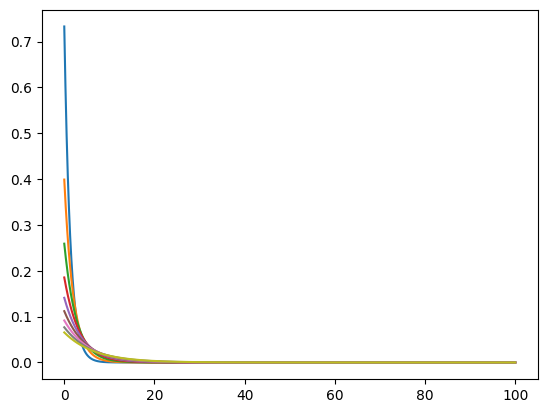

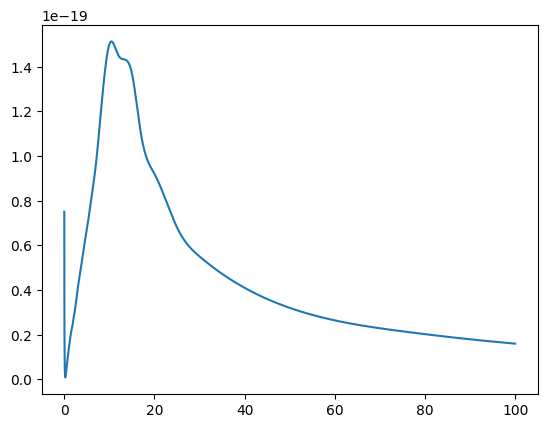

In [492]:
e_grid = np.arange(0,100,0.01)
cross = calculate_cross_section(R_cross_interpolator[0],e_grid)

EEDF2 = calculate_EEDF(type_EEDF,e_grid,2)
EEDF3 = calculate_EEDF(type_EEDF,e_grid,3)
EEDF4 = calculate_EEDF(type_EEDF,e_grid,4)
EEDF5 = calculate_EEDF(type_EEDF,e_grid,5)
EEDF6 = calculate_EEDF(type_EEDF,e_grid,6)
EEDF7 = calculate_EEDF(type_EEDF,e_grid,7)
EEDF8 = calculate_EEDF(type_EEDF,e_grid,8)
EEDF9 = calculate_EEDF(type_EEDF,e_grid,9)
EEDF10 = calculate_EEDF(type_EEDF,e_grid,10)
plt.plot(e_grid,EEDF2)
plt.plot(e_grid,EEDF3)
plt.plot(e_grid,EEDF4)
plt.plot(e_grid,EEDF5)
plt.plot(e_grid,EEDF6)
plt.plot(e_grid,EEDF7)
plt.plot(e_grid,EEDF8)
plt.plot(e_grid,EEDF9)
plt.plot(e_grid,EEDF10)
plt.show()

plt.plot(e_grid,cross)

In [493]:
def rate_coefficient(E_mean):
    max_dist = calculate_EEDF(type_EEDF,e_grid, E_mean)
    return np.sqrt(2 * qe / me) * np.trapz(max_dist * calculate_cross_section(R_cross_interpolator[2],e_grid) * e_grid,e_grid)

In [494]:
rate_coefficient(0.01)

0.0

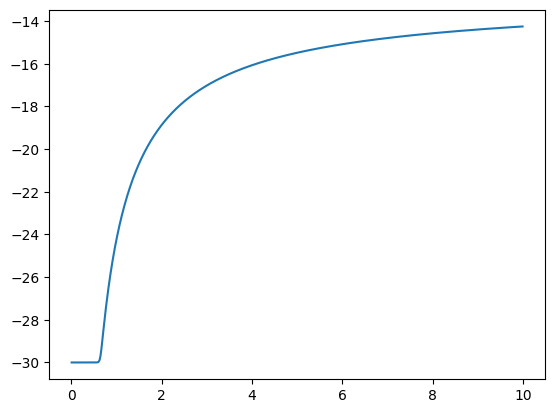

In [495]:
E_mean = np.arange(0.01,10,0.01)
RE = list(range(len(E_mean)))
for i in range(len(E_mean)):
    RE[i] = rate_coefficient(E_mean[i])+1e-30
plt.plot(E_mean,np.log10(RE))

In [496]:
# Electric properties
Vrf = -V0 * np.sin(w0) # applied voltage (V)
Vdiel = Qdiel / (eps0 * epsr * As / ddiel)
Vgap = Vdiel - 2 * Vdiel
E = Vgap / dgap
